# Digit Recognition Using SVM

We'll first explore the dataset a bit, prepare it (scale etc.) and then experiment with linear and non-linear SVMs with various hyperparameters.


## Data Understanding 

Let's first understand the shape, attributes etc. of the dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale


In [2]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [3]:
# dataset
digits = pd.read_csv("C:/Users/VIJAY/Desktop/DS/digit-recognizer/train.csv")

In [5]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
digits.shape

(42000, 785)

In [6]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [8]:
#checking duplicates
sum(digits.duplicated(subset = 'label')) == 0

False

In [10]:
# Checking for percentage nulls
round(100*(digits.isnull().sum()/len(digits.index)), 2)

label       0.0
pixel0      0.0
pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
pixel6      0.0
pixel7      0.0
pixel8      0.0
pixel9      0.0
pixel10     0.0
pixel11     0.0
pixel12     0.0
pixel13     0.0
pixel14     0.0
pixel15     0.0
pixel16     0.0
pixel17     0.0
pixel18     0.0
pixel19     0.0
pixel20     0.0
pixel21     0.0
pixel22     0.0
pixel23     0.0
pixel24     0.0
pixel25     0.0
pixel26     0.0
pixel27     0.0
pixel28     0.0
           ... 
pixel754    0.0
pixel755    0.0
pixel756    0.0
pixel757    0.0
pixel758    0.0
pixel759    0.0
pixel760    0.0
pixel761    0.0
pixel762    0.0
pixel763    0.0
pixel764    0.0
pixel765    0.0
pixel766    0.0
pixel767    0.0
pixel768    0.0
pixel769    0.0
pixel770    0.0
pixel771    0.0
pixel772    0.0
pixel773    0.0
pixel774    0.0
pixel775    0.0
pixel776    0.0
pixel777    0.0
pixel778    0.0
pixel779    0.0
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
Length: 785, dtype: floa

#### No Nulls present in the dataset

### Some EDA on the dataset before processing

In [11]:
# select pixel columns
data = digits.drop("label", axis = 1)

In [12]:
# convert pixel columns to array
data = data.as_matrix()

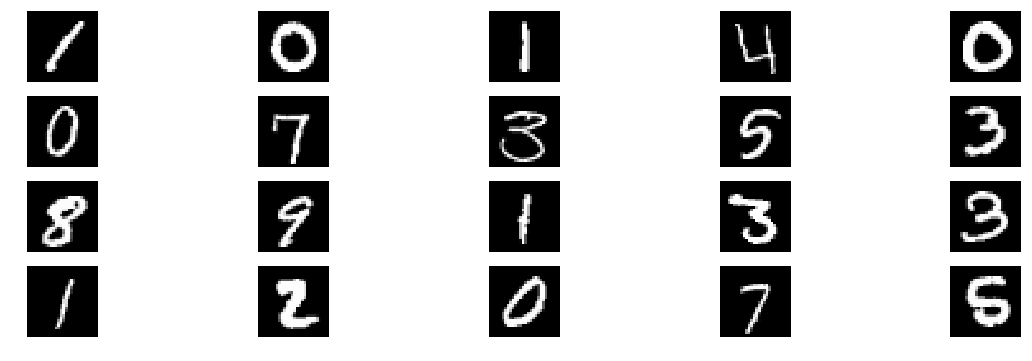

In [13]:
# plot some columns to check the shape of the digits

image=data.reshape(42000,28,28)

plt.figure(figsize=(20,6))
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.imshow(image[i], cmap=plt.get_cmap('gray'),interpolation='nearest')
    plt.axis('off')
   


### Check few rows to to match with labels

In [14]:
# Row 0
one = digits.iloc[0, 1:]
one.shape

(784,)

Text(0.5,1,'Label: 1')

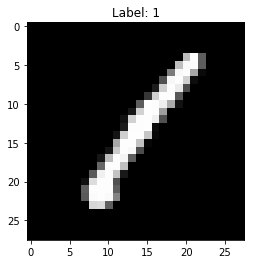

In [15]:
one = one.values.reshape(28, 28)
plt.imshow(one, cmap='gray')
plt.title('Label: 1')

In [16]:
# Row 1
zero = digits.iloc[1, 1:]
zero.shape

(784,)

Text(0.5,1,'Label: 0')

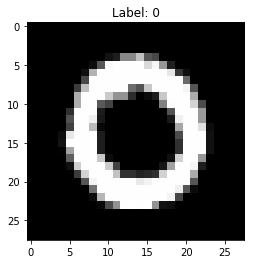

In [17]:
zero = zero.values.reshape(28, 28)
plt.imshow(zero, cmap='gray')
plt.title('Label: 0')

In [18]:
# Row 2
one_1 = digits.iloc[2, 1:]
one_1.shape

(784,)

Text(0.5,1,'Label: 1')

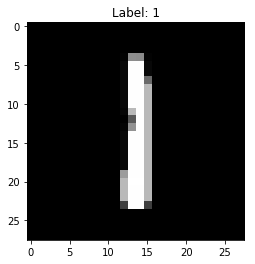

In [19]:
one_1 = one_1.values.reshape(28, 28)
plt.imshow(one_1, cmap='gray')
plt.title('Label: 1')

In [20]:
# Row 3
four = digits.iloc[3, 1:]
four.shape

(784,)

Text(0.5,1,'Label: 4')

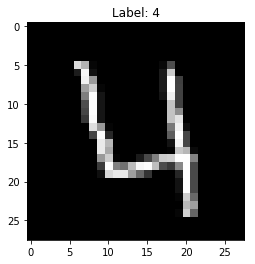

In [21]:
four = four.values.reshape(28, 28)
plt.imshow(four, cmap='gray')
plt.title('Label: 4')

In [22]:
# Row 5
zero_1 = digits.iloc[5, 1:]
zero_1.shape

(784,)

Text(0.5,1,'Label: 0')

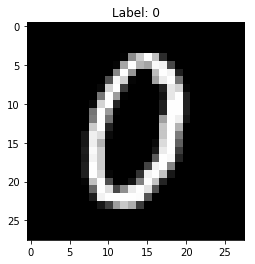

In [23]:
zero_1 = zero_1.values.reshape(28, 28)
plt.imshow(zero_1, cmap='gray')
plt.title('Label: 0')

In [24]:
digits.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [25]:
# Check label column

class_name = list(np.sort(digits['label'].unique()))
class_name


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

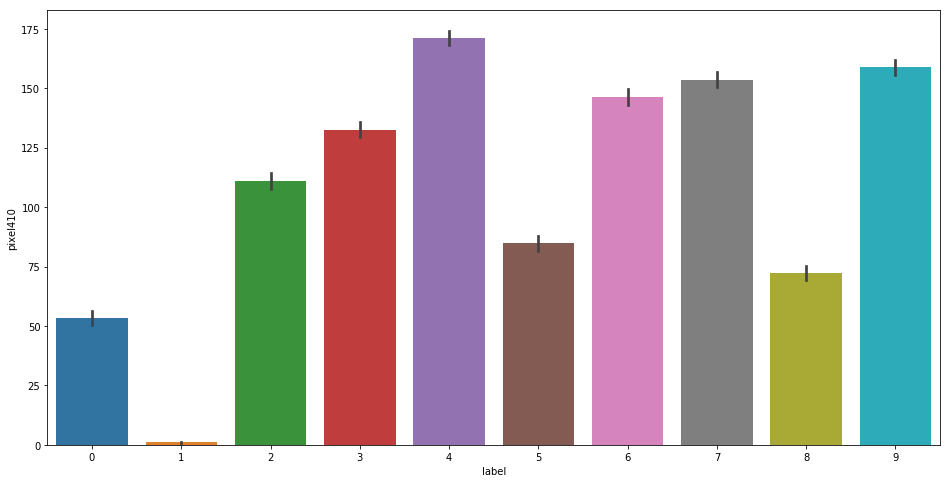

In [26]:
# basic plots: How do various attributes vary with the digits
# check for random column 'pixel410'
plt.figure(figsize=(16, 8))
sns.barplot(x='label', y='pixel410', 
            data=digits, 
            order=class_name)

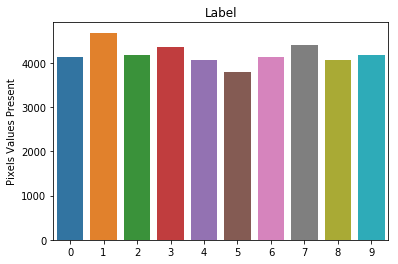

In [27]:
# check value counts for each class label

sns.barplot(x=digits.label.value_counts().index, y=digits.label.value_counts()).set_title('Label')
plt.ylabel('Pixels Values Present')
plt.show()

In [28]:
digits.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [29]:
digit_means = digits.groupby('label').mean()
digit_means.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Pixel values range from 0 to 255

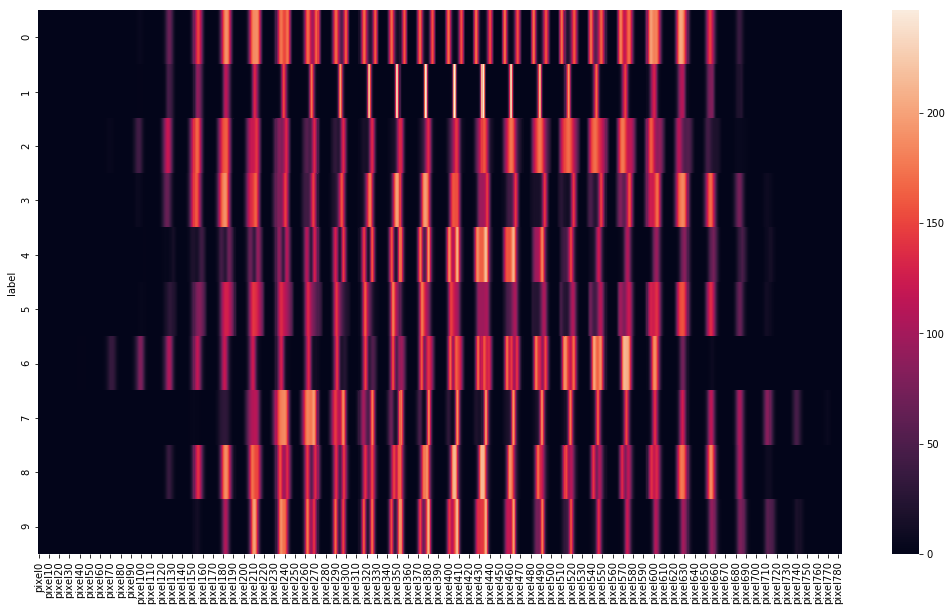

In [30]:
plt.figure(figsize=(18, 10))
sns.heatmap(digit_means)

## Data Processing

In [7]:
# splitting into X and y
X_train = digits.drop("label", axis = 1)
y_train = digits['label']

In [8]:
# scaling the features
X_scaled = scale(X_train)


from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train, train_size = 0.2, test_size = 0.8, random_state = 100)

#### Since it is a huge dataset, we will use only 20% of the data to Train the models and the rest 80% will be used as Test data

In [9]:
# check shapes after split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8400, 784)
(33600, 784)
(8400,)
(33600,)


## Model Building and Evaluation

In [34]:
# we will first try linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)


In [35]:
# confusion matrix and accuracy

print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred), "\n")

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision", metrics.precision_score(y_test, y_pred,average = 'weighted'))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred,average='weighted'))

[[3194    0   23    6   10   21   25    2    9    0]
 [   0 3669   21   13    3    5    1    6   26    4]
 [  44   24 3005   85   44   10   32   26   50   12]
 [  20   18   95 3131    4  129    5   19   61   29]
 [  14   10   36    7 2996   12   19   14    7  129]
 [  29   19   27  145   32 2701   51    6   62   17]
 [  55   10   53    4   28   54 3071    0   10    0]
 [  10   28   40   31   66    3    1 3169    5  144]
 [  25   68   57  151   22  111   26   23 2733   25]
 [  23   10   23   33  160    7    0  153   24 2930]] 

accuracy: 0.9106845238095238
precision 0.9107490916470817
sensitivity/recall 0.9106845238095238


In [36]:
# check classwise accuracy by checking f1 score for each class
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.97      0.95      3290
          1       0.95      0.98      0.97      3748
          2       0.89      0.90      0.90      3332
          3       0.87      0.89      0.88      3511
          4       0.89      0.92      0.91      3244
          5       0.88      0.87      0.88      3089
          6       0.95      0.93      0.94      3285
          7       0.93      0.91      0.92      3497
          8       0.91      0.84      0.88      3241
          9       0.89      0.87      0.88      3363

avg / total       0.91      0.91      0.91     33600



In [37]:
# check R-squared for linear model
print(metrics.r2_score(y_true=y_test, y_pred=y_pred))

0.8271209178987107


#### Linear model yields an accuracy score of around 91% with fair classwise accuracy i.e the prediction is not skewed through the class labels.  Though there is still scope to improve the R-Squared value.  

#### We will try non-linear models to check if the Accuracy and R-squared score is affected

In [38]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

In [39]:
# confusion matrix and accuracy

print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred), "\n")

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision", metrics.precision_score(y_test, y_pred,average = 'weighted'))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred,average='weighted'))

[[3199    0   32    2    3   13   28    1   12    0]
 [   0 3654   39   12    5    9    6    4   16    3]
 [  15    8 3190   21   22    2   16   22   29    7]
 [   5   14  123 3187    4   65    8   32   56   17]
 [   3    8   63    0 3029   10   18   13    7   93]
 [  12    7   47   82   17 2841   49    6   17   11]
 [  18    6   67    0   13   32 3140    0    9    0]
 [   1   26  117   11   21    3    1 3192    2  123]
 [  20   36   71   56   16   73   14   12 2918   25]
 [  14   12   64   38   56   10    1  109   24 3035]] 

accuracy: 0.9340773809523809
precision 0.935523805787196
sensitivity/recall 0.9340773809523809


In [40]:
# Check for any skewness classwise
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97      3290
          1       0.97      0.97      0.97      3748
          2       0.84      0.96      0.89      3332
          3       0.93      0.91      0.92      3511
          4       0.95      0.93      0.94      3244
          5       0.93      0.92      0.92      3089
          6       0.96      0.96      0.96      3285
          7       0.94      0.91      0.93      3497
          8       0.94      0.90      0.92      3241
          9       0.92      0.90      0.91      3363

avg / total       0.94      0.93      0.93     33600



In [41]:
# Check R-squared value for non-llinear model
metrics.r2_score(y_true=y_test, y_pred=y_pred)

0.8671878974245113

#### It is observed that the overall Accuracy, R-squared as well as classwise accuracy is improved by using a non-linear 'RBF' model with default hyperparameters

#### We will check with Polynomial model, if it has any positive effect on the accuracy

In [43]:
# POLYNOMIAL model

model_poly = SVC(kernel='poly')
model_poly.fit(X_train, y_train)

# predict
y_pred = model_poly.predict(X_test)


In [44]:
# confusion matrix and accuracy

print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred), "\n")

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision", metrics.precision_score(y_test, y_pred,average = 'weighted'))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred,average='weighted'))

[[2930    0    8    5   41    9   28    0  268    1]
 [   0 3649   13    1   14    0    7    2   60    2]
 [   5   16 2564   32  121    2   13   13  559    7]
 [   3   13   35 2835   23   10    8   13  540   31]
 [   2   11   19    2 3070   10    5    3   21  101]
 [   7    1    5   98   89 2117   30    4  689   49]
 [  13    9   12    0   85   20 2951    0  195    0]
 [   1   46    6   10  158    1    0 2766  115  394]
 [   6   15   28   28   21   33    0    4 3080   26]
 [   9   13   11   19  161    4    0   45   89 3012]] 

accuracy: 0.8623214285714286
precision 0.8947306924338736
sensitivity/recall 0.8623214285714286


In [45]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.98      0.89      0.94      3290
          1       0.97      0.97      0.97      3748
          2       0.95      0.77      0.85      3332
          3       0.94      0.81      0.87      3511
          4       0.81      0.95      0.87      3244
          5       0.96      0.69      0.80      3089
          6       0.97      0.90      0.93      3285
          7       0.97      0.79      0.87      3497
          8       0.55      0.95      0.70      3241
          9       0.83      0.90      0.86      3363

avg / total       0.89      0.86      0.87     33600



In [46]:
# R-squared for polynomial model
metrics.r2_score(y_true=y_test, y_pred=y_pred)

0.6856536044409985

#### It is observed that Polynomial model performed poorly on this dataset. The Accuracy and R-squared values are too low as compared to Linear and RBF models.
#### Therefore, we will not consider 'Polynomial model' for final model building.

#### Since, the RBF model has yielded highest accuracy and R-squared scores, we will tune the hyperparameters for the RBF and choose the best 'C' and 'Gamma' values

### KFold Crossvalidation to tune the Hyperparameters for 'RBF' model

In [263]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101, )

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 421.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [264]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,178.434394,3.190288,21.717992,3.705545,1,0.01,"{'C': 1, 'gamma': 0.01}",0.738095,0.773810,0.754762,...,0.750952,0.013292,12,1.000000,0.999851,1.000000,0.999851,0.999851,0.999911,0.000073
1,43.576158,2.233086,11.087794,2.194088,1,0.001,"{'C': 1, 'gamma': 0.001}",0.934524,0.932738,0.942857,...,0.935238,0.003973,4,0.975298,0.974256,0.975000,0.974554,0.975446,0.974911,0.000447
2,60.940653,1.730669,18.055244,0.565921,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.904167,0.894643,0.912500,...,0.899167,0.008018,8,0.914732,0.917262,0.913244,0.914881,0.916220,0.915268,0.001372
3,3185.926331,6056.208191,19.324309,3.105117,10,0.01,"{'C': 10, 'gamma': 0.01}",0.752976,0.791667,0.773810,...,0.768095,0.014338,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,27.325966,1.892672,7.742459,0.483218,10,0.001,"{'C': 10, 'gamma': 0.001}",0.941667,0.946429,0.951786,...,0.943690,0.006112,1,0.999405,0.999554,0.999554,0.999702,0.999702,0.999583,0.000111
5,24.521717,2.469872,8.059430,1.765344,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.928571,0.926190,0.936310,...,0.928571,0.005120,6,0.963095,0.964137,0.962202,0.964286,0.963839,0.963512,0.000773
6,205.491237,13.656694,23.885845,2.889306,100,0.01,"{'C': 100, 'gamma': 0.01}",0.752976,0.791667,0.773810,...,0.768095,0.014338,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,41.690472,2.379547,13.723695,2.076276,100,0.001,"{'C': 100, 'gamma': 0.001}",0.941071,0.945238,0.952976,...,0.943571,0.006633,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,24.693696,4.671310,10.518391,1.391869,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.932143,0.934524,0.936310,...,0.929048,0.007891,5,0.995387,0.996429,0.996131,0.996280,0.994048,0.995655,0.000880
9,244.405124,7.536470,30.586952,6.589106,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.752976,0.791667,0.773810,...,0.768095,0.014338,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


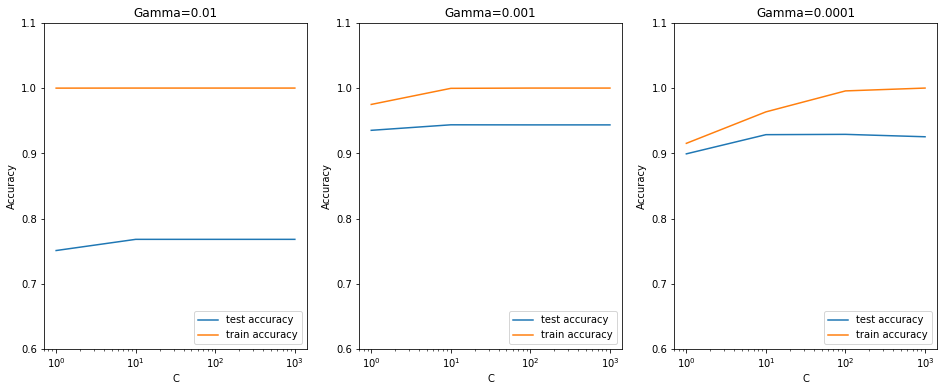

In [265]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


In [266]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9436904761904762 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [10]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [11]:
# confusion matrix and accuracy

print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred), "\n")

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision", metrics.precision_score(y_test, y_pred,average = 'weighted'))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred,average='weighted'))

[[3216    0   24    1    3   13   20    1   12    0]
 [   0 3666   33   10    5    3    5    6   16    4]
 [  14   13 3188   33   16    2   18   17   25    6]
 [   5    4   90 3249    3   52    9   22   58   19]
 [   6    8   49    0 3059    7   12   14    9   80]
 [   9    6   38   70   11 2869   47    6   19   14]
 [  26    3   56    1   14   29 3146    0   10    0]
 [   4   24   88   17   29    2    0 3268    4   61]
 [  16   19   59   61   17   65   13   10 2957   24]
 [  17    8   53   23   63    9    1   95   14 3080]] 

accuracy: 0.9433928571428571
precision 0.9441691897065326
sensitivity/recall 0.9433928571428571


In [12]:
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97      3290
          1       0.98      0.98      0.98      3748
          2       0.87      0.96      0.91      3332
          3       0.94      0.93      0.93      3511
          4       0.95      0.94      0.95      3244
          5       0.94      0.93      0.93      3089
          6       0.96      0.96      0.96      3285
          7       0.95      0.93      0.94      3497
          8       0.95      0.91      0.93      3241
          9       0.94      0.92      0.93      3363

avg / total       0.94      0.94      0.94     33600



In [13]:
print(metrics.r2_score(y_true=y_test, y_pred=y_pred))

0.8829152232266027


In [14]:
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

In [15]:
# Class wise Accuracy
100*matrix.diagonal()/matrix.sum(axis=1)

array([97.75075988, 97.81216649, 95.67827131, 92.53773854, 94.297164  ,
       92.87795403, 95.76864536, 93.45152988, 91.23727245, 91.58489444])

#### All the class labels have an accuracy above 90% 

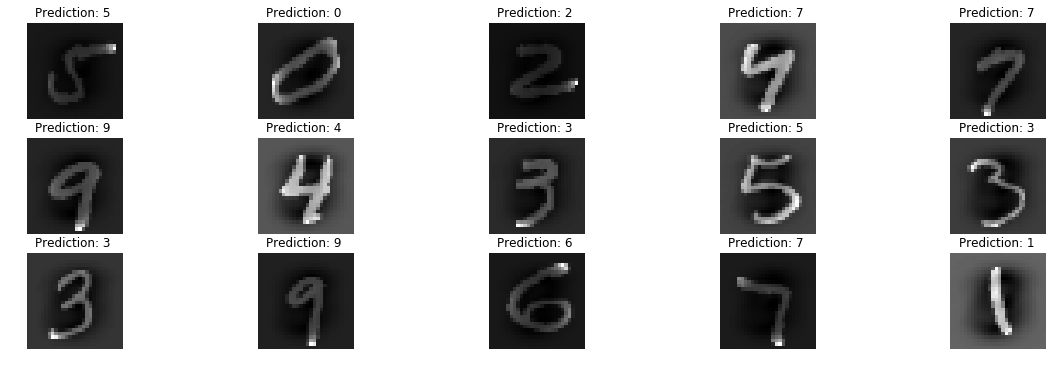

In [51]:
# Crosscheck the Predictions to match with the Pixel images

image=X_test.reshape(33600,28,28)

plt.figure(figsize=(20,6))
for i in range(0,15):
    plt.subplot(3,5,i+1)
    plt.imshow(image[i], cmap=plt.get_cmap('gray'),interpolation='nearest')
    plt.axis('off')
    plt.title('Prediction: {} '.format(y_pred[i]))

#### Therefore, the model with RBF, C at 10 and Gamma at 0.001 were chosen for Predicting the digits.

## ------------------------------------------------- THE END ------------------------------------------------------